<a href="https://colab.research.google.com/github/Salma-Jamal/Leaf-Segmentation-Classification/blob/main/Leaf_Segmentation_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Leaf Segmentation & Classification
The project's objective is to develop a model capable of both segmenting leaf images and categorizing them into one of 38 classes, distinguishing between diseased and healthy leaves.



*  The dataset utilized in this project is the [PlantVillage-Dataset](https://github.com/spMohanty/PlantVillage-Dataset) containing images of leaves, corresponding masks, and spanning across 38 distinct classes.

*   Our methodology comprises two primary phases:

      1.  Creating [COCO-annotations](https://cocodataset.org/#home) in order to train a Mask R-CNN model using [Detectron2](https://github.com/facebookresearch/detectron2). Since the dataset contains masks in image format, we need to convert them into the COCO format.

      2.   Train the Detectron2 model using the COCO-annotations JSON file generated and the provided dataset.






## Download Dataset & packages

In [1]:
!git clone https://github.com/spMohanty/PlantVillage-Dataset

Cloning into 'PlantVillage-Dataset'...
remote: Enumerating objects: 163229, done.
remote: Total 163229 (delta 0), reused 0 (delta 0), pack-reused 163229
Receiving objects: 100% (163229/163229), 2.00 GiB | 29.94 MiB/s, done.
Resolving deltas: 100% (99/99), done.
Updating files: 100% (182401/182401), done.


In [ ]:
!pip install wandb

## Imports

In [2]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import seaborn as sns
from tqdm import tqdm_notebook
import os
from PIL import Image
import numpy as np
import json
from pycocotools import mask
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import re
import wandb

In [43]:
run = wandb.init(project='Classification_Segmentation_of_Plant_disease')

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Display Dataset Samples


*   A Sample → ( Image , Mask)




In [3]:
root_dir = '/content/PlantVillage-Dataset/raw'
classes_names = sorted(os.listdir("/content/PlantVillage-Dataset/raw/color"))

In [ ]:
images , masks , classes = [],[],[]
for plant_class in classes_names[:3]:
  plant_class_imgs = sorted(os.listdir(os.path.join(root_dir,'color',plant_class)))
  plant_class_masks = sorted(os.listdir(os.path.join(root_dir,'segmented',plant_class)))

  for img,mask in zip(plant_class_imgs,plant_class_masks):
    if img.split("-")[0] ==  mask.split("-")[0]:
      images.append(cv2.imread(os.path.join(root_dir,'color',plant_class,img)))
      masks.append(cv2.imread(os.path.join(root_dir,'segmented',plant_class,mask)))
      classes.append(plant_class)

In [ ]:
def name(class_name):
    """
    Map the class-name to be first and last word only for visualization purposes.
    Parameters:
        class_name (str): The name of class.

    Returns:
        (str): Mapped class name
    """
    first = re.sub(r'[^a-zA-Z]+', ' ', class_name).strip().split(' ')[0]
    last = re.sub(r'[^a-zA-Z]+', ' ', class_name).strip().split(' ')[-1]
    return first+" "+last

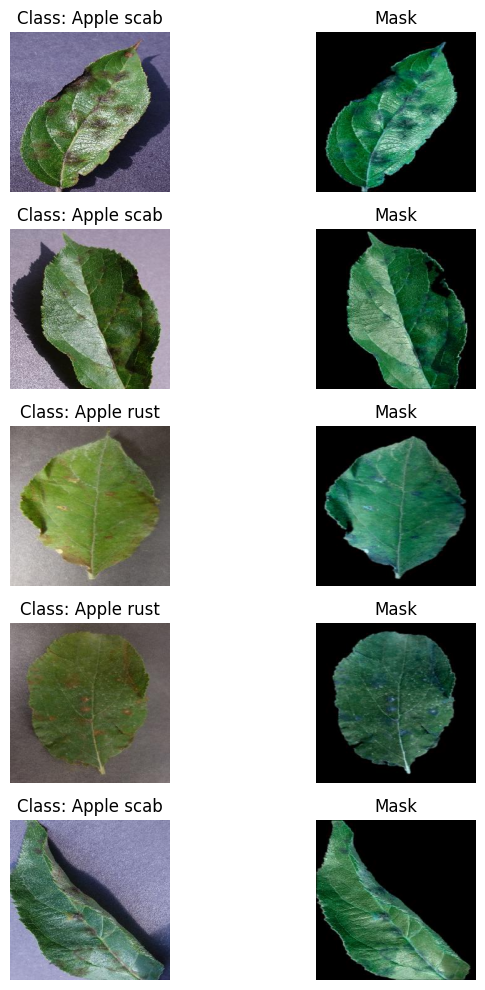

In [ ]:
num_images_to_plot = 5
indices_to_plot = np.random.choice(len(images), num_images_to_plot, replace=False)
fig, axes = plt.subplots(num_images_to_plot, 2, figsize=(10, 2 * num_images_to_plot))
for i, idx in enumerate(indices_to_plot):
    image = images[idx]
    mask = masks[idx]
    plant_class = classes[idx]

    axes[i, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[i, 0].set_title(f'Class: {name(plant_class)}')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(mask, cmap='viridis')
    axes[i, 1].set_title('Mask')
    axes[i, 1].axis('off')

plt.tight_layout(w_pad=-10.0)
plt.show()


## Create COCO-Format Annotations

### Load dataset from directories

In [4]:
def prepareData(root_path,class_names,New_shape):
  """
  Prepare data for image segmentation tasks by loading and resizing images and masks.

  Args:
      root_path (str): The root directory containing the images and masks subdirectories.
      class_names (list): A list of class names to process.
      New_shape (tuple): A tuple specifying the new shape (width, height) for resizing images and masks.

  Returns:
      tuple: A tuple containing the following elements:
          - images (list): A list of resized color images.
          - masks (list): A list of resized mask images in grayscale.
          - classes (list): A list of class names corresponding to the processed images and masks.
          - images_list (list): A list of image information dictionaries with 'id', 'file_name', 'width', and 'height' fields.
  """
  images = []
  masks = []
  classes = []
  images_list = []

  image_id = 0
  for class_name in class_names[:2]:
    image_dir = os.path.join(root_path,'color',class_name)
    mask_dir =  os.path.join(root_path,'segmented',class_name)

    image_filenames = sorted(os.listdir(image_dir))
    mask_filenames = sorted(os.listdir(mask_dir))


    for image_filename,mask_filename in tqdm_notebook(zip(image_filenames,mask_filenames)):
      if image_filename.split('-')[0] == mask_filename.split('-')[0]:


        image_path = os.path.join(image_dir, image_filename)
        image = cv2.imread(image_path)
        resized_image = cv2.resize(image, New_shape)
        images.append(resized_image)


        mask_path = os.path.join(mask_dir, mask_filename)
        mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
        resized_mask = cv2.resize(mask, New_shape)
        masks.append(np.array(resized_mask))

        image_width, image_height,_ = image.shape

        image_info = {
            'id': image_id,
            'file_name': image_path ,
            'width': image_width,
            'height': image_height,
        }

        classes.append(class_name)
        images_list.append(image_info)
        image_id+=1

  return  images, masks, classes, images_list

In [51]:
root_path = '/content/PlantVillage-Dataset/raw/'
class_names = sorted(os.listdir('/content/PlantVillage-Dataset/raw/color/'))

In [52]:
images, masks, classes, images_list  = prepareData(root_path,class_names,(256, 256))

<ipython-input-4-5b5771188389>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for image_filename,mask_filename in tqdm_notebook(zip(image_filenames,mask_filenames)):


0it [00:00, ?it/s]

0it [00:00, ?it/s]

### Create categories list

In [7]:
categories = dict(enumerate(class_names))
categories = {v: k+1 for k, v in categories.items()}

In [8]:
categories_list= []
for k,v in categories.items():
  class_info = {'id':v,'name':k}
  categories_list.append(class_info)

In [9]:
categories_list

[{'id': 1, 'name': 'Apple___Apple_scab'},
 {'id': 2, 'name': 'Apple___Black_rot'},
 {'id': 3, 'name': 'Apple___Cedar_apple_rust'},
 {'id': 4, 'name': 'Apple___healthy'},
 {'id': 5, 'name': 'Blueberry___healthy'},
 {'id': 6, 'name': 'Cherry_(including_sour)___Powdery_mildew'},
 {'id': 7, 'name': 'Cherry_(including_sour)___healthy'},
 {'id': 8, 'name': 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'},
 {'id': 9, 'name': 'Corn_(maize)___Common_rust_'},
 {'id': 10, 'name': 'Corn_(maize)___Northern_Leaf_Blight'},
 {'id': 11, 'name': 'Corn_(maize)___healthy'},
 {'id': 12, 'name': 'Grape___Black_rot'},
 {'id': 13, 'name': 'Grape___Esca_(Black_Measles)'},
 {'id': 14, 'name': 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)'},
 {'id': 15, 'name': 'Grape___healthy'},
 {'id': 16, 'name': 'Orange___Haunglongbing_(Citrus_greening)'},
 {'id': 17, 'name': 'Peach___Bacterial_spot'},
 {'id': 18, 'name': 'Peach___healthy'},
 {'id': 19, 'name': 'Pepper,_bell___Bacterial_spot'},
 {'id': 20, 'name': 'Peppe

### Extract objects annotations data


*   **Bounding Box:** a rectangular shape that outlines an object or region of interest within an image.

*   **Segmentation:** a series of interconnected vertices that outline the boundaries of objects within an image.

*   **Area:** The pixel area of a segmented object in an image.


In [55]:
def bbox(mask):
    """
    Calculate the bounding box of a binary mask.

    Args:
        mask (numpy.ndarray): A binary mask represented as a NumPy array.

    Returns:
        list: A list containing the coordinates and dimensions of the bounding box in the format [x, y, width, height].
    """
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    x, y, w, h = cv2.boundingRect(np.vstack(contours))

    return [float(x), float(y), float(w), float(h)]


In [58]:
bbox(masks[6])

[48.0, 8.0, 184.0, 248.0]

In [11]:
def polygonSegmentation(img_mask):
    """
    Extract a polygon segmentation from a binary mask image.

    Args:
        img_mask (numpy.ndarray): A binary mask image where the object of interest is white (255) and the background is black (0).

    Returns:
        list: A list containing the coordinates of the polygon vertices in the format [x1, y1, x2, y2, ..., xn, yn], where (xi, yi) are the coordinates of the vertices.
    """
    img_mask[img_mask != 0] = 255
    edges = cv2.Canny(img_mask, threshold1=30, threshold2=100)
    edge_coordinates = np.column_stack(np.where(edges != 0))
    edge_coordinates = edge_coordinates.flatten()

    if len(edge_coordinates) == 0:
        return edge_coordinates.tolist()
    else:
        segmentation = edge_coordinates
        segmentation = segmentation.tolist()
        segmentation = [float(i) for i in segmentation]
        if segmentation[:2] == segmentation[-2:]:
            return segmentation
        else:
            segmentation.append(segmentation[0])
            segmentation.append(segmentation[1])
            return segmentation


In [12]:
polygon_mask = polygonSegmentation(masks[1])
print(polygon_mask)

[0.0, 192.0, 0.0, 198.0, 0.0, 200.0, 0.0, 201.0, 0.0, 204.0, 0.0, 206.0, 0.0, 207.0, 0.0, 208.0, 0.0, 210.0, 0.0, 211.0, 0.0, 213.0, 1.0, 193.0, 1.0, 195.0, 1.0, 200.0, 2.0, 192.0, 2.0, 195.0, 2.0, 200.0, 2.0, 208.0, 2.0, 213.0, 2.0, 214.0, 3.0, 192.0, 3.0, 197.0, 3.0, 198.0, 3.0, 199.0, 3.0, 203.0, 3.0, 205.0, 3.0, 206.0, 3.0, 207.0, 3.0, 208.0, 3.0, 212.0, 3.0, 215.0, 4.0, 196.0, 4.0, 201.0, 4.0, 202.0, 4.0, 203.0, 4.0, 209.0, 4.0, 210.0, 4.0, 211.0, 4.0, 212.0, 4.0, 216.0, 5.0, 194.0, 5.0, 199.0, 5.0, 213.0, 5.0, 214.0, 5.0, 215.0, 6.0, 191.0, 6.0, 193.0, 6.0, 197.0, 6.0, 198.0, 6.0, 199.0, 6.0, 215.0, 7.0, 168.0, 7.0, 169.0, 7.0, 172.0, 7.0, 173.0, 7.0, 174.0, 7.0, 180.0, 7.0, 181.0, 7.0, 182.0, 7.0, 183.0, 7.0, 186.0, 7.0, 187.0, 7.0, 188.0, 7.0, 191.0, 7.0, 197.0, 7.0, 215.0, 8.0, 167.0, 8.0, 172.0, 8.0, 175.0, 8.0, 176.0, 8.0, 177.0, 8.0, 184.0, 8.0, 185.0, 8.0, 189.0, 8.0, 190.0, 8.0, 215.0, 9.0, 167.0, 9.0, 172.0, 9.0, 173.0, 9.0, 178.0, 9.0, 179.0, 9.0, 215.0, 10.0, 167.0, 10

In [13]:
def calculate_area(poly):
    """
    Calculate the area of a polygon defined by its vertices using the shoelace formula.

    Args:
        poly (list): A list of vertices [x1, y1, x2, y2, ..., xn, yn] representing the polygon.

    Returns:
        float: The calculated area of the polygon.
    """
    n = len(poly) // 2
    x = poly[:n]
    y = poly[n:]

    area = 0.5 * abs(sum(x[i] * y[i + 1] - x[i + 1] * y[i] for i in range(n - 1)) + x[-1] * y[0] - x[0] * y[-1])
    return area

In [14]:
calculate_area(polygon_mask)

18942.5

### Create the coco-format annotations json file

In [15]:
def createCocoAnnotations(images, masks, classes, images_list):
    """
    Create COCO-style annotations for a set of images and masks.

    Args:
        images (list): A list of color images.
        masks (list): A list of binary mask images.
        classes (list): A list of class labels corresponding to the images and masks.
        images_list (list): A list of image information dictionaries.

    Returns:
        dict: A dictionary containing COCO-style annotations, including 'images', 'annotations', and 'categories'.
    """
    annotation_id = 1
    annotations = []

    for image_id, (image, mask, img_class) in tqdm_notebook(enumerate(zip(images, masks, classes))):
        bounding_box = bbox(mask)
        seg = polygonSegmentation(mask)
        area = calculate_area(seg)
        seg = np.flip(np.array([seg]), axis=1).tolist()

        annotation = {
            'id': annotation_id,
            'image_id': image_id,
            'category_id': categories[img_class],
            'segmentation': seg,
            'bbox': bounding_box,
            'area': float(area),
            'iscrowd': 0
        }
        annotations.append(annotation)
        annotation_id += 1

    coco_data = {
        'images': images_list,
        'annotations': annotations,
        'categories': categories_list
    }

    with open('coco_annotations.json', 'w') as json_file:
        json.dump(coco_data, json_file)

    return coco_data

In [ ]:
coco_data = createCocoAnnotations(images, masks,classes,images_list)

In [17]:
coco_data.keys()

dict_keys(['images', 'annotations', 'categories'])

### Visualize Image

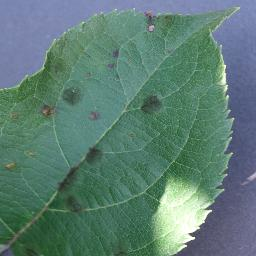

In [18]:
test_img = cv2.imread(coco_data['images'][2]['file_name'])
cv2_imshow(test_img)

### Visualize Image with Bounding Box

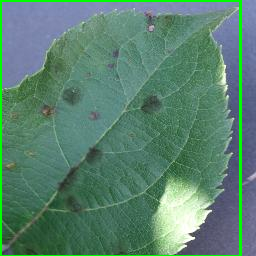

In [19]:
bbox = coco_data['annotations'][2]['bbox']

bbox = [int(i) for i in bbox]

cv2.rectangle(test_img, (bbox[0], bbox[1]), (bbox[0] + bbox[2], bbox[1] + bbox[3]), (0, 255, 0), 2)

cv2_imshow(test_img)
cv2.waitKey(0)
cv2.destroyAllWindows()


### Visualize Polygon segmentation

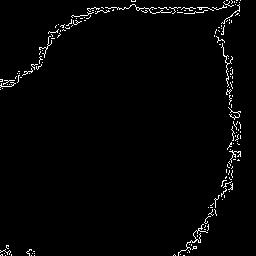

In [49]:
segmentation = coco_data['annotations'][2]['segmentation'][0]

segmentation = np.flip(np.array(segmentation)).tolist()

height, width,_ = test_img.shape
blank_image = np.zeros((height, width), dtype=np.uint8)


segmentation = [int(i) for i in segmentation]

s = np.array(segmentation).reshape(-1,2)
for row, col in s:
    blank_image[row, col] = 255

# Display the result (press any key to close)
cv2_imshow(blank_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Finetune Detectron2 Model

### Install libraries & imports

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

In [23]:
import os
import numpy as np
import torch
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetMapper
from detectron2.data import build_detection_test_loader
from detectron2.data import build_detection_train_loader
from detectron2.data import transforms as T
from detectron2.engine import DefaultTrainer
import random
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode

### Register Training Dataset

In [24]:
register_coco_instances("train_data", {}, "/content/coco_annotations.json", "/content/PlantVillage-Dataset/raw")

In [25]:
my_dataset_train_metadata = MetadataCatalog.get("train_data")
dataset_dicts = DatasetCatalog.get("train_data")

### Visualize sample Images with masks

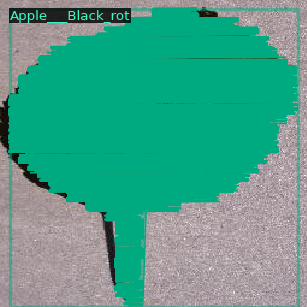

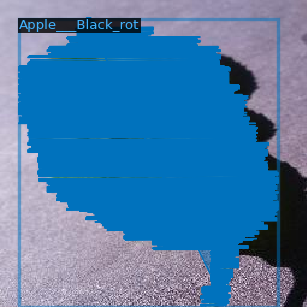

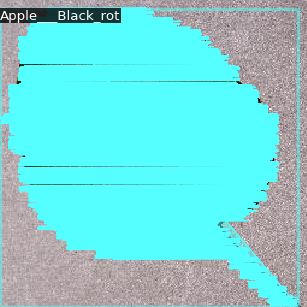

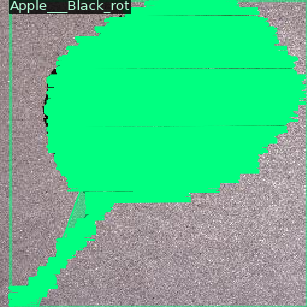

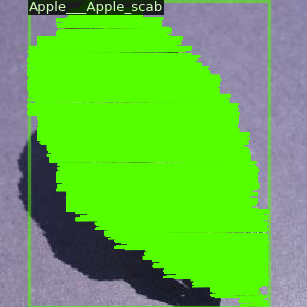

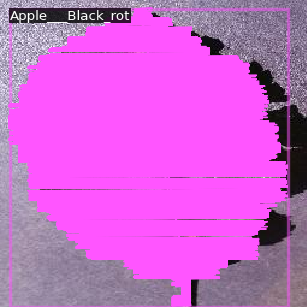

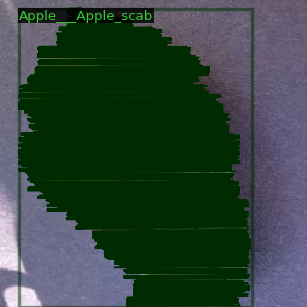

In [26]:
for d in random.sample(dataset_dicts, 7):
  img = cv2.imread(d["file_name"])
  visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=1.2)
  vis = visualizer.draw_dataset_dict(d)
  cv2_imshow(vis.get_image()[:, :, ::-1])

### Model Configurations

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train_data",)
cfg.DATASETS.TEST = ()

cfg.INPUT.MIN_SIZE_TRAIN = (256,)
cfg.INPUT.MAX_SIZE_TRAIN = 256
cfg.INPUT.MIN_SIZE_TRAIN_SAMPLING = "choice"
cfg.INPUT.MIN_SIZE_TEST = 256
cfg.INPUT.MAX_SIZE_TEST  = 256

cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 35000
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 38
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)


### Training

In [27]:
trainer.resume_or_load(resume=False)
trainer.train()

[09/03 02:09:07 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:01, 173MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[09/03 02:09:10 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[09/03 02:09:23 d2.utils.events]:  eta: 1:16:52  iter: 19  total_loss: 5.439  loss_cls: 3.741  loss_box_reg: 0.9978  loss_mask: 0.6972  loss_rpn_cls: 0.001723  loss_rpn_loc: 0.00232    time: 0.1337  last_time: 0.1278  data_time: 0.0149  last_data_time: 0.0045   lr: 4.9953e-06  max_mem: 812M
[09/03 02:09:34 d2.utils.events]:  eta: 1:42:22  iter: 39  total_loss: 5.161  loss_cls: 3.503  loss_box_reg: 0.9914  loss_mask: 0.6863  loss_rpn_cls: 0.001279  loss_rpn_loc: 0.002185    time: 0.2390  last_time: 0.1732  data_time: 0.0130  last_data_time: 0.0059   lr: 9.9903e-06  max_mem: 812M
[09/03 02:09:36 d2.utils.events]:  eta: 1:20:03  iter: 59  total_loss: 4.671  loss_cls: 2.951  loss_box_reg: 0.9988  loss_mask: 0.6686  loss_rpn_cls: 0.001126  loss_rpn_loc: 0.001681    time: 0.2033  last_time: 0.1348  data_time: 0.0089  last_data_time: 0.0049   lr: 1.4985e-05  max_mem: 812M
[09/03 02:09:39 d2.utils.events]:  eta: 1:18:42  iter: 79  total_loss: 3.576  loss_cls: 1.989  loss_box_reg: 0.9452  loss_

In [44]:
artifact = wandb.Artifact('Detectron2_35K', type='model')
artifact.add_file('/content/output/model_final.pth')
run.log_artifact(artifact)

<Artifact Detectron2_35K>

### Inference
Download and load checkpoint
* [Model Checkpoint](https://wandb.ai/pedestrian-segmentation/Classification_Segmentation_of_Plant_disease/artifacts/model/Detectron2_35K/v0/files)

In [45]:
artifact = run.use_artifact('pedestrian-segmentation/Classification_Segmentation_of_Plant_disease/Detectron2_35K:v0', type='model')
artifact_dir = artifact.download()

wandb: Downloading large artifact Detectron2_35K:v0, 336.28MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.0


In [46]:
cfg.MODEL.WEIGHTS = '/content/artifacts/Detectron2_35K:v0/model_final.pth' #os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1
predictor = DefaultPredictor(cfg)

[09/03 03:56:34 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/artifacts/Detectron2_35K:v0/model_final.pth ...


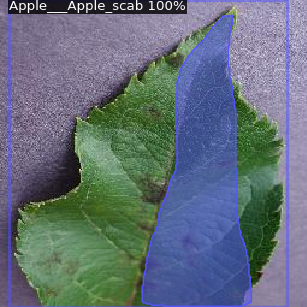

In [47]:
im = cv2.imread('/content/PlantVillage-Dataset/raw/color/Apple___Apple_scab/0896ecbc-1af2-4868-8279-ed302acb29bc___FREC_Scab 3339.JPG')
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
               metadata=my_dataset_train_metadata,
                scale=1.2,
                instance_mode= ColorMode.IMAGE   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

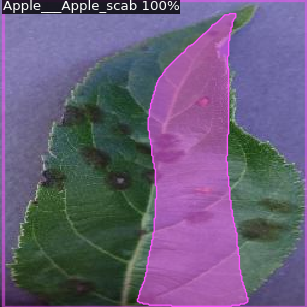

In [31]:
im = cv2.imread('/content/PlantVillage-Dataset/raw/color/Apple___Apple_scab/01a66316-0e98-4d3b-a56f-d78752cd043f___FREC_Scab 3003.JPG')
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
               metadata=my_dataset_train_metadata,
                scale=1.2,
                instance_mode= ColorMode.IMAGE   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

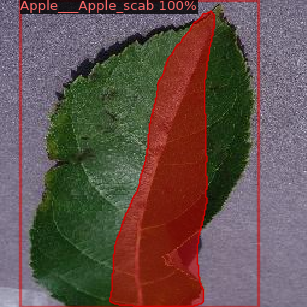

In [35]:
im = cv2.imread('/content/PlantVillage-Dataset/raw/color/Apple___Apple_scab/0395b847-2c73-4674-826f-33a6afb5b4fe___FREC_Scab 3287.JPG')
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
               metadata=my_dataset_train_metadata,
                scale=1.2,
                instance_mode= ColorMode.IMAGE   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

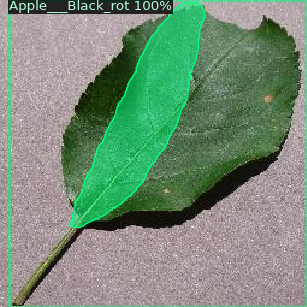

In [88]:
im = cv2.imread('/content/PlantVillage-Dataset/raw/color/Apple___Black_rot/4fcfd5b0-e312-41f4-a8cf-16976b5882fd___JR_FrgE.S 8589.JPG')
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
               metadata=my_dataset_train_metadata,
                scale=1.2,
                instance_mode= ColorMode.IMAGE)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

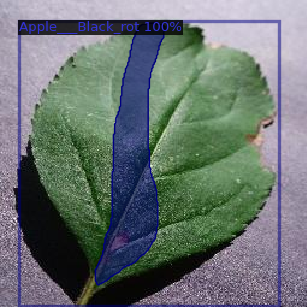

In [96]:
im = cv2.imread('/content/PlantVillage-Dataset/raw/color/Apple___Black_rot/d8e21bad-015b-4b76-8ffa-373b191ed448___JR_FrgE.S 3021.JPG')
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
               metadata=my_dataset_train_metadata,
                scale=1.2,
                instance_mode= ColorMode.IMAGE)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

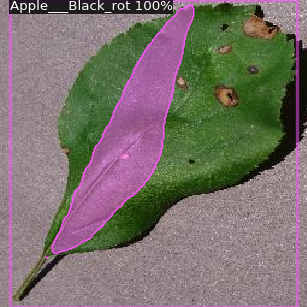

In [92]:
im = cv2.imread('/content/PlantVillage-Dataset/raw/color/Apple___Black_rot/497e0a24-9a4e-4ace-8aa3-d60751b03abe___JR_FrgE.S 8794.JPG')
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
               metadata=my_dataset_train_metadata,
                scale=1.2,
                instance_mode= ColorMode.IMAGE)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])



*  The model demonstrates high accuracy in classifying the object's class and accurately detecting its bounding box. However, there is room for improvement in the quality of the segmentation masks.

* Enhancing the model's performance further would ideally require training on a larger dataset over an extended period. Unfortunately, due to limited computational resources, we were unable to pursue this approach.
